# Using Naive-Bayes Classifier on MNIST

### 优缺点
- Pros：在数据较少的情况下仍然有效，可以处理多类别问题
- Cons：对于输入数据的准备方式较为敏感
- 适用数据类型：标称型数据

### 一般过程
- 数据处理
    - 收集数据：可以适用任何方法，如RSS源或爬虫等，也可以直接导入外部数据集或者自己杜撰
    - 准备数据：需要数值型或者bool型数据
    - 分析数据：有大量特征时，绘制特征作用不大， 此时使用直方图效果更好
- 算法模型
    - 训练算法：计算不同的独立特征的条件概率
    - 测试算法：计算错误率
- 结论
    - 使用算法：一个常见的朴素贝叶斯应用是文本分类，可以在任意的分类场景中使用朴素贝叶斯分类器，不一定非要是文本

In [1]:
#文档头文件
import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, model_selection
from sklearn.metrics import classification_report
from collections import Counter
from sklearn.naive_bayes import GaussianNB

## 数据处理

### 收集数据：[使用 OpenML 数据集](https://www.openml.org/d/554)
[Using sklearn fetch_openml function to fetch dataset from openml by name or dataset id](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html)

In [2]:
#通过sklearn导入数据集，并观察数据集的规模
mnist = datasets.fetch_openml('mnist_784')
data, target = mnist.data, mnist.target
data.shape, target.shape

((70000, 784), (70000,))

data[0]:
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
  18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
 253. 253. 253. 253. 225. 172. 253. 242. 195.  64.   0.   0.   0.  

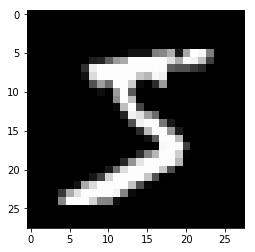

In [4]:
#观察数据样例
plt.gray()
print("data[0]:\n", data[0])
print("target[0]:", target[0])
print()
plt.imshow(data[0].reshape(28,28))

通过对 data[0] 的观察，我们发现data[0]的数据类型大约为浮点型，且数据区间为0.～255.,下面对其进行进一步观察。

In [9]:
print("min: ", min(data[0]))
print("max: ", max(data[0]))
print("mean: ", np.mean(data[0]))
print("data.dtype: ", data.dtype)
print("target.dtype: ", target.dtype)

min:  0.0
max:  255.0
mean:  35.108418367346935
data.dtype:  float64
target.dtype:  object


### 准备数据

通过对数据的观察，我们知道我们的训练集的数据格式为(70000, 784)，与上一个例子中的敏感消息分类任务相比，其 document_num = 70000, word_num = 784。

但是在 minst 数据集中，其每一个 word 对应的值的浮动区间为 0.~255.，且为浮点数，不是二值问题，所以我们需要对其进行二值化。

二值化，主要有两个方法：
1. 将一个 image 中所有大于 0 的 pixel 值都设置为 1。（bool型）
2. 取所有 pixel 的均值，小于均值的设为 0， 其余为 1。（均值型）

这里，我对这两种方法都进行实现。

#### 使用方法一（bool型二值化方法）进行二值化

In [13]:
def bool_normalize(data):
    image_num, pixel_num = data.shape
    bool_data = np.zeros((image_num, pixel_num))
    for i in range(image_num):
        for j in range(pixel_num):
            if int(data[i, j]) != 0:
                bool_data[i,j] = 1
            else:
                bool_data[i,j] = 0
    return bool_data

In [15]:
bool_data = bool_normalize(data)

min:  0.0
max:  1.0


Text(0.5, 0, '1')

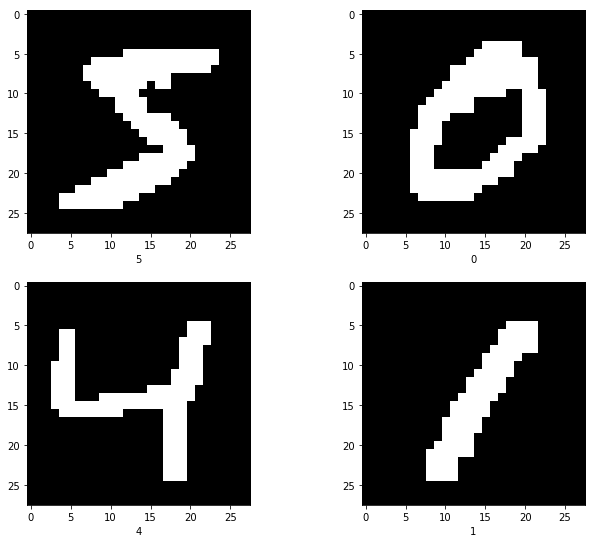

In [36]:
print("min: ", min(bool_data[0]))
print("max: ", max(bool_data[0]))

plt.figure(figsize=(10,10))                  
plt.subplots_adjust(wspace =0.5, hspace =0)  

plt.subplot(2,2,1)
plt.imshow(bool_data[0].reshape(28,28))
plt.xlabel(target[0])

plt.subplot(2,2,2)
plt.imshow(bool_data[1].reshape(28,28))
plt.xlabel(target[1])

plt.subplot(2,2,3)
plt.imshow(bool_data[2].reshape(28,28))
plt.xlabel(target[2])

plt.subplot(2,2,4)
plt.imshow(bool_data[3].reshape(28,28))
plt.xlabel(target[3])

#### 使用方法二（均值型二值化方法）进行二值化

In [14]:
def mean_normalize(data):
    image_num, pixel_num = data.shape
    mean_data = np.zeros((image_num, pixel_num))
    for i in range(image_num):
        image_pixel_mean = data[i].mean()
        for j in range(pixel_num):
            if data[i,j] < image_pixel_mean:
                mean_data[i,j] = 0
            else:
                mean_data[i,j] = 1
    return mean_data

In [22]:
mean_data = mean_normalize(data)

min:  0.0
max:  1.0


Text(0.5, 0, '1')

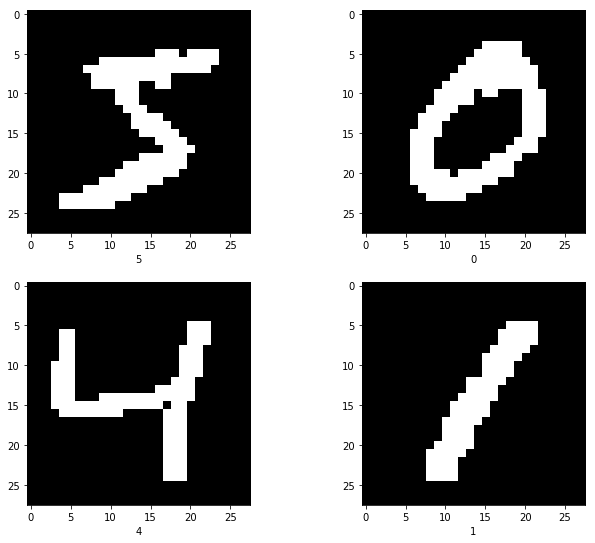

In [37]:
print("min: ", min(mean_data[0]))
print("max: ", max(mean_data[0]))

plt.figure(figsize=(10,10))                  
plt.subplots_adjust(wspace =0.5, hspace =0)  

plt.subplot(2,2,1)
plt.imshow(mean_data[0].reshape(28,28))
plt.xlabel(target[0])

plt.subplot(2,2,2)
plt.imshow(mean_data[1].reshape(28,28))
plt.xlabel(target[1])

plt.subplot(2,2,3)
plt.imshow(mean_data[2].reshape(28,28))
plt.xlabel(target[2])

plt.subplot(2,2,4)
plt.imshow(mean_data[3].reshape(28,28))
plt.xlabel(target[3])

通过对比两种二值化方法得到的图像结果，我觉得使用第一种（bool型）二值化的方法得到的结果更加好，于是决定使用bool型二值化来对我们的样本数据进行处理。

#### 转换数据类型

In [44]:
print("bool_data.dtype: ", bool_data.dtype)
print("target.dtype: ", target.dtype)
print()
print(target)

bool_data.dtype:  float64
target.dtype:  object

['5' '0' '4' ... '4' '5' '6']


我们发现训练集的数据类型，不是非常客观，这对于我们后面进行数值比较和索引、算数运算等操作不是很友好，所以统一统统转化成int型。

In [49]:
bool_data = bool_data.astype(np.int32)
target = target.astype(np.int32)
print("bool_data.dtype: ", bool_data.dtype)
print("target.dtype: ", target.dtype)
print()
print(target)

bool_data.dtype:  int32
target.dtype:  int32

[5 0 4 ... 4 5 6]


#### 训练集和测试集样本分割

In [38]:
#生成一个随机数组
indx = np.random.choice(len(target), len(target), replace=False)

#构建一定长度大小的新 data 和 target 数组
def mk_dataset(size, data, target):
    train_X = [data[i] for i in indx[:size]]
    train_X = np.array(train_X)
    train_y = [target[i] for i in indx[:size]]
    train_y = np.array(train_y)
    
    return train_X, train_y

In [50]:
#生成训练集的样本和标签
train_X, train_y = mk_dataset(50000, bool_data, target)
train_X.shape, train_y.shape

((50000, 784), (50000,))

In [51]:
#生成测试集的样本和标签
def mk_test_dataset(data, target):
    test_X = [data[i] for i in indx[-10000:]]
    test_X = np.array(test_X)
    test_y = [target[i] for i in indx[-10000:]]
    test_y = np.array(test_y)
    
    return test_X, test_y

test_X, test_y = mk_test_dataset(bool_data, target)
test_X.shape, test_y.shape

((10000, 784), (10000,))

## 算法模型
由于在前面的一个实验（敏感信息分类）中，已经构建好了我们的 naive-bayes classifier，所以可以直接沿用它的代码结果，做一定的改进。改进主要是由于这是一个多分类（十分类）问题，而上一个实验是一个二分类问题。

### 训练算法

In [110]:
def trainNB0(trainMatrix, trainCategory):
    #dataset's image num, per image's pixel num
    images_num, pixel_num = np.shape(trainMatrix)
    
    #先验概率
    #calculate label num
    label_counter = Counter(trainCategory)
    label_num = len(list(label_counter))
    #按照key的数值顺序排列（0~9）
    label_sort = list(label_counter)
    label_sort.sort()
    #计算先验概率
    prior_probability = np.array([label_counter[label_sort[i]]/images_num for i in range(label_num)])
#     print("prior_probability: \n", prior_probability)
    
    #条件概率
    conditional_Num = np.ones((label_num, pixel_num))
    conditional_Denom = 10.0 * np.ones(label_num)
    conditional_probability = np.zeros((label_num, pixel_num))
    for i in range(images_num):
        for now_label in label_sort:
            if trainCategory[i] == now_label:
                conditional_Num[now_label] += trainMatrix[i]
                conditional_Denom[now_label] += sum(trainMatrix[i])
    
    
    for now_label in label_sort:
#         print("p%sNum: \n%s\n" % (now_label, conditional_Num[now_label]))
#         print("p%sDenom: \n%s\n" % (now_label, conditional_Denom[now_label]))
#         print("p%sNum.SHAPE: \n%s\n" % (now_label, conditional_Num[now_label].shape))
#         print("p%sDenom.SHAPE: \n%s\n" % (now_label, conditional_Denom[now_label].shape))
        conditional_probability[now_label] = np.log(conditional_Num[now_label]/float(conditional_Denom[now_label]))
    
    return prior_probability, conditional_probability

In [111]:
priorP, conditionalP = trainNB0(train_X, train_y)

In [112]:
print("priorP:\n", priorP)
print("\n-----------------------------------------------\n")
print("conditionalP:\n", conditionalP)
print("\nconditionalP.shape:\n", conditionalP.shape)

priorP:
 [0.09684 0.11258 0.09988 0.10228 0.0976  0.08972 0.099   0.10564 0.09784
 0.09862]

-----------------------------------------------

conditionalP:
 [[-13.7442562  -13.7442562  -13.7442562  ... -13.7442562  -13.7442562
  -13.7442562 ]
 [-13.09199489 -13.09199489 -13.09199489 ... -13.09199489 -13.09199489
  -13.09199489]
 [-13.6465237  -13.6465237  -13.6465237  ... -13.6465237  -13.6465237
  -13.6465237 ]
 ...
 [-13.45023733 -13.45023733 -13.45023733 ... -13.45023733 -13.45023733
  -13.45023733]
 [-13.65057695 -13.65057695 -13.65057695 ... -13.65057695 -13.65057695
  -13.65057695]
 [-13.46898253 -13.46898253 -13.46898253 ... -13.46898253 -13.46898253
  -13.46898253]]

conditionalP.shape:
 (10, 784)


### 测试算法

In [124]:
def classifyNB(vec2Classify, priorP, conditionalP, label_num):
    #取log，将条件概率与先验概率之间的乘法操作，变成了加法操作
    #另外，我们需要在 c_i 取不同 label 时，
    #分别通过贝叶斯公式来计算此时的后验概率。
    posterP = np.empty(label_num)
    max_P = -np.Inf
    max_index = -1
    for i in range(label_num):
        posterP[i] = sum(vec2Classify * conditionalP[i]) + np.log(priorP[i])
        if posterP[i] > max_P:
            max_P, max_index = posterP[i], i
    
    return max_index

In [125]:
def testNB(test_X, priorP, conditionalP):
    image_num = test_X.shape[0]
    pred_y = np.empty(image_num)
    for sample in range(image_num):
        pred_y[sample] = classifyNB(test_X[sample], priorP, conditionalP, 10)
    return pred_y

In [129]:
pred_y = testNB(test_X, priorP, conditionalP)

In [130]:
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90      1029
           1       0.88      0.94      0.91      1121
           2       0.88      0.82      0.85      1010
           3       0.77      0.79      0.78      1019
           4       0.79      0.69      0.74       942
           5       0.84      0.59      0.69       916
           6       0.87      0.90      0.88       976
           7       0.92      0.80      0.86      1009
           8       0.61      0.76      0.67       967
           9       0.67      0.81      0.73      1011

   micro avg       0.80      0.80      0.80     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000

